This notebook include:
1. Searchlight-level preprocess and threshold choice
2. Second-level analysis on Recall (not included in paper)
3. Searchlight-level recall prediction result visualization and analysis

In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from nilearn import plotting
from nilearn.glm import threshold_stats_img
from scipy.stats import ttest_1samp
from nilearn.reporting import get_clusters_table

In [13]:
from nilearn.image import math_img
def mask_t_map(t_map, p_map, threshold_p=0.05):
    # result = t_map * (logp_map > threshold)
    # not satisfying threshold will be 0
    masked_t = math_img(
        f'img1 * (img2 < {threshold_p})', 
        img1=t_map, 
        img2=p_map
    )
    return masked_t

### 1. Data Preprocess
Examine the memorability of each image and the distribution of memory abilities among the participants to select the sample

In [2]:
behav = pd.read_csv('data/free_recall_order.csv')

In [3]:
subject_stats = behav.groupby('subjectID')['recall'].agg(['mean', 'std'])
subject_stats

,mean,std
subjectID,,
1015,0.291667,0.457719
1016,0.347222,0.479428
1017,0.416667,0.496466
1018,0.527778,0.502731
1020,0.694444,0.463875
...,...,...
1112,0.555556,0.500391
1113,0.277778,0.451046
1114,0.569444,0.498629


In [7]:
picture_stats = behav.groupby('pictureID')['recall'].agg(['mean', 'std'])
picture_stats

,mean,std
pictureID,,
3,0.38,0.487832
4,0.63,0.485237
5,0.43,0.497570
6,0.54,0.500908
7,0.25,0.435194
...,...,...
92,0.19,0.394277
94,0.18,0.386123
95,0.33,0.472582


##### subject filtration more statistical based make no sense

In [ ]:
def get_iqr_bounds(data, multiplier=1.5):
    """
    calc IQR boundaries
    return: (lower_bound, upper_bound), valid_mask
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    lower_bound = q1 - (multiplier * iqr)
    upper_bound = q3 + (multiplier * iqr)

    valid_mask = (data >= lower_bound) & (data <= upper_bound)
    
    return (lower_bound, upper_bound), valid_mask, (q1, q3, iqr)

def plot_distribution_with_bounds(data, bounds, title="Distribution"):
    """
    histogram + boxplot + boundary lines
    """
    lower, upper = bounds
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                          gridspec_kw={"height_ratios": (.15, .85)},
                                          figsize=(10, 6))
    
    # boxplot
    sns.boxplot(x=data, ax=ax_box, color='lightblue')
    ax_box.axvline(lower, color='r', linestyle='--', label='Lower Bound')
    ax_box.axvline(upper, color='r', linestyle='--', label='Upper Bound')
    ax_box.set(xlabel='')
    
    # histogram
    sns.histplot(data, ax=ax_hist, kde=True)
    ax_hist.axvline(lower, color='r', linestyle='--', linewidth=2)
    ax_hist.axvline(upper, color='r', linestyle='--', linewidth=2)
    
    plt.suptitle(title)
    plt.xlabel('Mean Recall Rate')
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.show()

In [ ]:
# subject recall IQR
(sub_lower, sub_upper), sub_keep_mask, _ = get_iqr_bounds(subject_stats['mean'], multiplier=1.5)

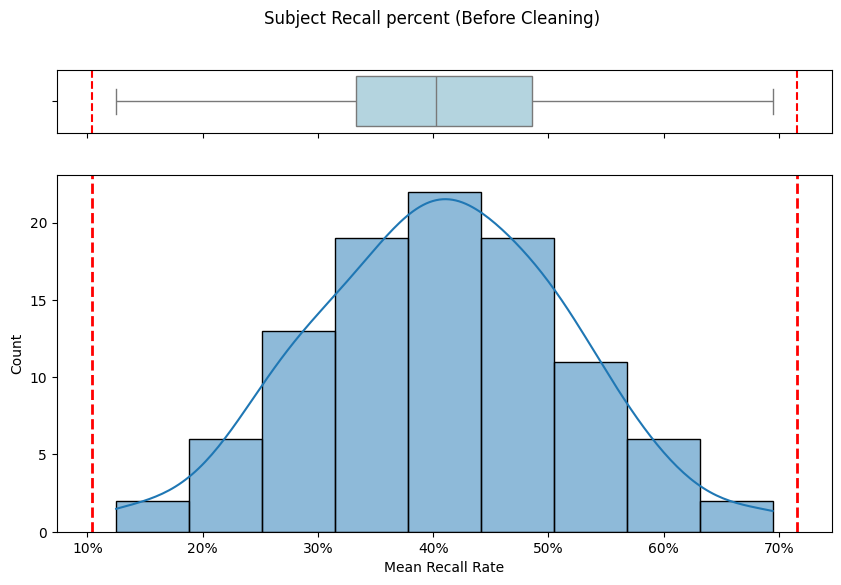

In [ ]:
plot_distribution_with_bounds(subject_stats['mean'], (sub_lower, sub_upper), "Subject Recall percent (Before Cleaning)")

In [ ]:
# pic recall IQR
(pic_lower, pic_upper), pic_keep_mask, _ = get_iqr_bounds(picture_stats['mean'], multiplier=1.5)

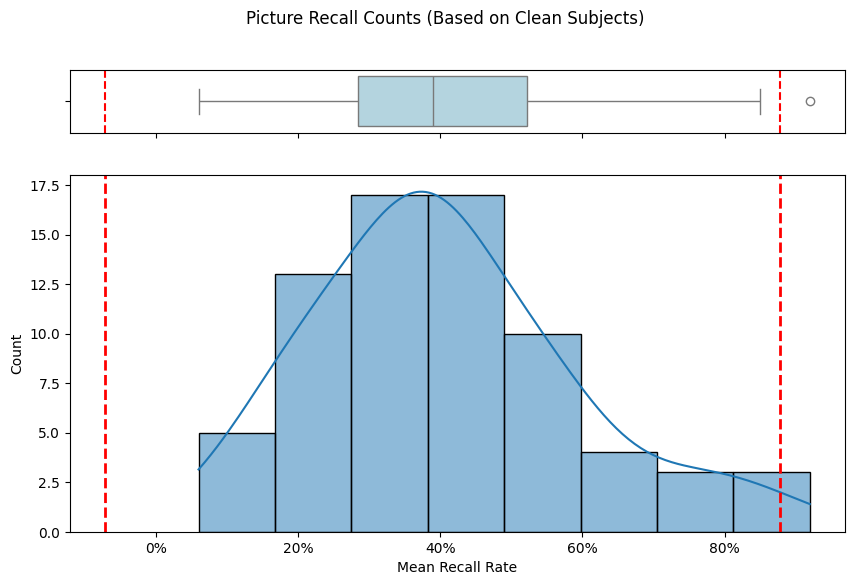

In [ ]:
plot_distribution_with_bounds(picture_stats['mean'], (pic_lower, pic_upper), "Picture Recall Counts (Based on Clean Subjects)")

##### set threshold manually
find parameters that could generate stable second-level result

In [ ]:
# read in data
recall_matrix = np.load('data/free_recall_mat.npy')  # shape: (100, 72)
beta = np.load('data/full_encoding_data_5d.npy')  # shape: (67, 80, 46, 100, 72)
mask_img = nib.load("atlas/mask_all_valid_voxels.nii.gz")
mask_data = nib.load("atlas/mask_all_valid_voxels.nii.gz").get_fdata()
mask_bool = mask_data.astype(bool) 
n_voxels = np.sum(mask_bool)
print(f"Mask contains {n_voxels} voxels.")
masked_beta = beta[mask_bool, :, :]
print(masked_beta.shape)
masked_beta = masked_beta.transpose(1, 2, 0) # (subject, pic, valid voxels)
print(masked_beta.shape)

In [5]:
recall_matrix.shape

(100, 72)

In [ ]:
# check different thresholds' result
# find most stable results rather than cherry-picking

sub_thr_list = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
pic_thr_list = [0.10, 0.15, 0.20, 0.25, 0.30]

# results storage
shape = (len(sub_thr_list), len(pic_thr_list))
mat_t_max = np.zeros(shape)
mat_n_vox001 = np.zeros(shape)
mat_n_vox05 = np.zeros(shape)
annot_samples = [] # for N_sub / N_pic visualize


for i, s_thr in enumerate(sub_thr_list):
    row_annot = []
    for j, p_thr in enumerate(pic_thr_list):
        # STEP 1 sub selection
        low_thr = s_thr
        high_thr = 1.0 - low_thr
        recall_by_sub = np.mean(recall_matrix, axis=1)
        keep_sub_mask = (recall_by_sub >= low_thr) & (recall_by_sub <= high_thr)
        n_subs_kept = np.sum(keep_sub_mask)
        # too little subjects, skip
        if n_subs_kept < 10:
            mat_t_max[i, j] = np.nan
            mat_n_vox001[i, j] = np.nan
            mat_n_vox05[i, j] = np.nan
            row_annot.append("Ns<10")
            continue
        # sub data
        temp_recall_filt_sub = recall_matrix[keep_sub_mask, :]          # [n_kept, 72]
        temp_masked_beta_filt_sub = masked_beta[keep_sub_mask, :, :]    # [n_kept, 72, n_voxels]
        
        # STEP 2 pic selection
        # count number
        recall_by_pic = np.sum(temp_recall_filt_sub, axis=0)
        # at least 12R, 8F
        min_R = max(int(n_subs_kept * p_thr), 12)
        min_F = max(int(n_subs_kept * p_thr), 8)
        keep_pic_mask = (recall_by_pic >= min_R) & (recall_by_pic <= (n_subs_kept - min_F))
        n_pic_kept = np.sum(keep_pic_mask)
        if n_pic_kept < 10:
            mat_t_max[i, j] = np.nan
            mat_n_vox001[i, j] = np.nan
            mat_n_vox05[i, j] = np.nan
            row_annot.append("Np<10")
            continue
        final_recall = temp_recall_filt_sub[:, keep_pic_mask]       # [n_kept, n_pic_kept]
        final_data = temp_masked_beta_filt_sub[:, keep_pic_mask, :] # [n_kept, n_pic_kept, n_voxels]
        
        # STEP 3 calc R-F
        contrasts = []
        valid_sub_count = 0
        for s in range(n_subs_kept):
            r_mask = (final_recall[s, :] == 1)
            f_mask = (final_recall[s, :] == 0)
            # Check if valid (has both R and F trials)
            if np.sum(r_mask) == 0 or np.sum(f_mask) == 0:
                print(f"Warning: Subject {s} has 0 R or F after pic, filling contrast with 0s.")
                pass
            else:
                mean_r = np.mean(final_data[s, r_mask, :], axis=0) # voxels
                mean_f = np.mean(final_data[s, f_mask, :], axis=0)
                contrasts.append(mean_r - mean_f) 
                valid_sub_count += 1
                
        contrasts = np.array(contrasts) # [n_kept, n_voxels]
        
        # STEP 4 Group t test
        if valid_sub_count < 10:
            mat_t_max[i, j] = np.nan
            mat_n_vox001[i, j] = np.nan
            mat_n_vox05[i, j] = np.nan
            row_annot.append("N<10")
        else:
            t_vals, p_vals = ttest_1samp(contrasts, popmean=0, axis=0, alternative='greater')
            # Metric 1: Peak T (Mean of top 100 voxels)
            top_t = np.mean(np.sort(t_vals)[-100:])
            mat_t_max[i, j] = top_t
            # Metric 2: Significant Voxels Count
            n_sig_001 = np.sum(p_vals < 0.001)
            n_sig_05 = np.sum(p_vals < 0.05)
            mat_n_vox001[i, j] = n_sig_001
            mat_n_vox05[i, j] = n_sig_05
            # Record sample size string for annotation
            row_annot.append(f"{n_subs_kept}\n{n_pic_kept}")
            
            print(f"Sub {s_thr:.0%} | Pic {p_thr:.0%} -> T={top_t:.2f}, Vox(001)={n_sig_001} (N_s={n_subs_kept}, N_p={n_pic_kept})")   
    annot_samples.append(row_annot)


Sub 15% | Pic 10% -> T=2.06, Vox(001)=0 (N_s=98, N_p=69)
Sub 15% | Pic 15% -> T=2.07, Vox(001)=0 (N_s=98, N_p=68)
Sub 15% | Pic 20% -> T=1.95, Vox(001)=0 (N_s=98, N_p=61)
Sub 15% | Pic 25% -> T=1.80, Vox(001)=0 (N_s=98, N_p=55)
Sub 15% | Pic 30% -> T=2.10, Vox(001)=0 (N_s=98, N_p=48)
Sub 20% | Pic 10% -> T=2.03, Vox(001)=0 (N_s=97, N_p=69)
Sub 20% | Pic 15% -> T=2.02, Vox(001)=0 (N_s=97, N_p=68)
Sub 20% | Pic 20% -> T=1.97, Vox(001)=0 (N_s=97, N_p=61)
Sub 20% | Pic 25% -> T=1.86, Vox(001)=0 (N_s=97, N_p=55)
Sub 20% | Pic 30% -> T=2.16, Vox(001)=0 (N_s=97, N_p=48)
Sub 25% | Pic 10% -> T=1.99, Vox(001)=0 (N_s=95, N_p=69)
Sub 25% | Pic 15% -> T=1.98, Vox(001)=0 (N_s=95, N_p=68)
Sub 25% | Pic 20% -> T=1.96, Vox(001)=0 (N_s=95, N_p=60)
Sub 25% | Pic 25% -> T=1.85, Vox(001)=0 (N_s=95, N_p=56)
Sub 25% | Pic 30% -> T=2.06, Vox(001)=0 (N_s=95, N_p=47)
Sub 30% | Pic 10% -> T=2.48, Vox(001)=0 (N_s=82, N_p=69)
Sub 30% | Pic 15% -> T=2.48, Vox(001)=0 (N_s=82, N_p=69)
Sub 30% | Pic 20% -> T=2.47, Vo

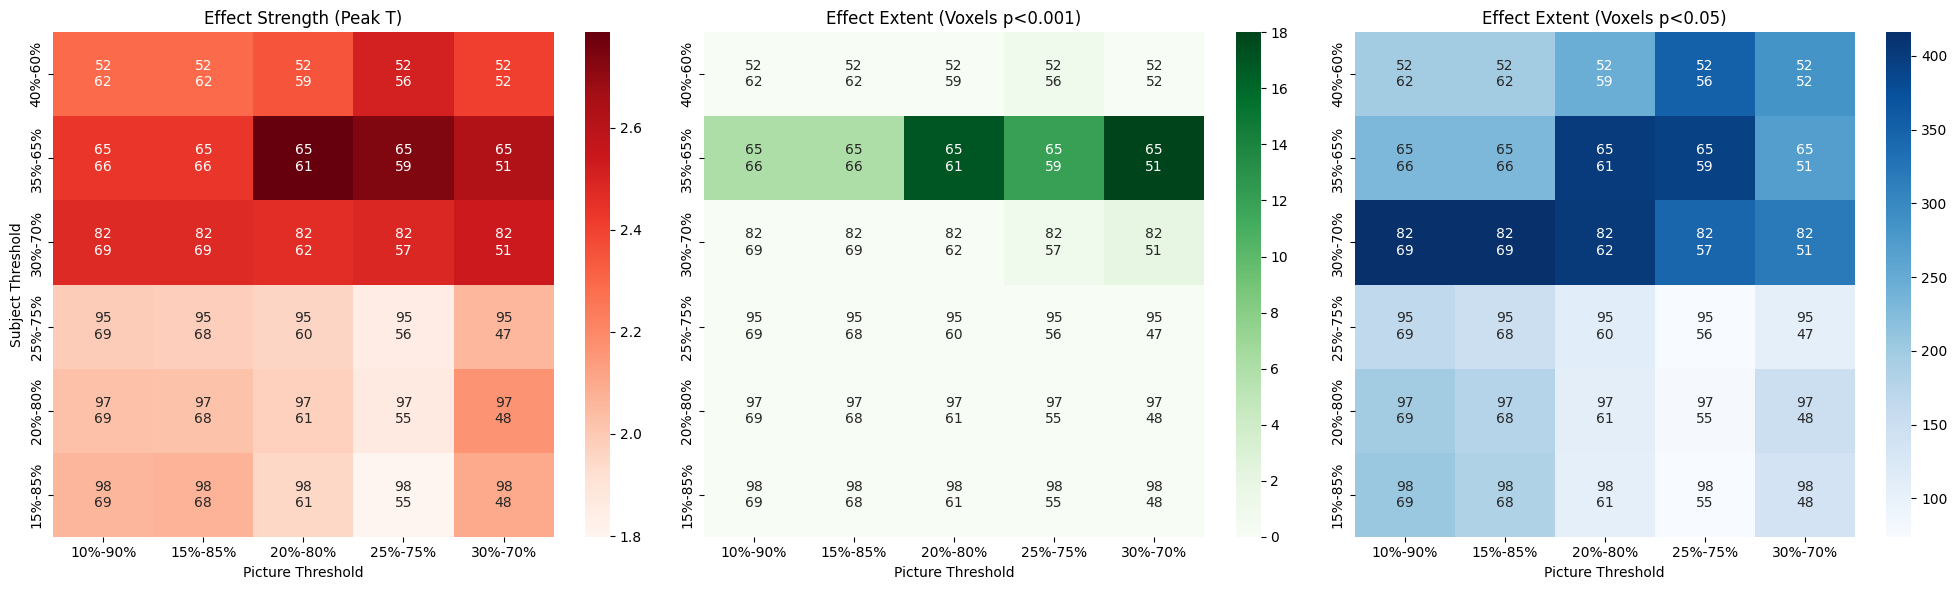

In [ ]:
# Visualization

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# label in % format
xticklabels = [f"{x:.0%}-{1-x:.0%}" for x in pic_thr_list]
yticklabels = [f"{y:.0%}-{1-y:.0%}" for y in sub_thr_list]

# Plot 1: Peak T-value
sns.heatmap(mat_t_max, annot=np.array(annot_samples), fmt="", 
            cmap="Reds", ax=axes[0],
            xticklabels=xticklabels, yticklabels=yticklabels)
axes[0].set_title('Effect Strength (Peak T)')
axes[0].set_ylabel('Subject Threshold')
axes[0].set_xlabel('Picture Threshold')
axes[0].invert_yaxis()

# Plot 2: Voxel Count (p<0.001)
sns.heatmap(mat_n_vox001, annot=np.array(annot_samples), fmt="", 
            cmap="Greens", ax=axes[1],
            xticklabels=xticklabels, yticklabels=yticklabels)
axes[1].set_title('Effect Extent (Voxels p<0.001)')
axes[1].set_xlabel('Picture Threshold')
axes[1].invert_yaxis()

# Plot 3: Voxel Count (p<0.05) - Optional
sns.heatmap(mat_n_vox05, annot=np.array(annot_samples), fmt="", 
            cmap="Blues", ax=axes[2],
            xticklabels=xticklabels, yticklabels=yticklabels)
axes[2].set_title('Effect Extent (Voxels p<0.05)')
axes[2].set_xlabel('Picture Threshold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

so we settle the threshold at subject 30%-70%, picture 10%-90% (least 12 Recall, 8F) with most common and least trial removement

### 2. Based on GLM and one-sample test (second-level voxel-wise)
this part result is not presented in paper, just put here for reference  
no statistical-significant voxel

In [25]:
recall_matrix.shape, masked_beta.shape

((100, 72), (100, 72, 42699))

In [26]:
# select subs
s_thr = 0.3
recall_by_sub = np.mean(recall_matrix, axis=1)
keep_sub_mask = (recall_by_sub >= s_thr) & (recall_by_sub <= (1-s_thr))
n_subs_kept = np.sum(keep_sub_mask)
print(n_subs_kept)
recall_filt_sub = recall_matrix[keep_sub_mask, :]
masked_beta_filt_sub = masked_beta[keep_sub_mask, :, :]
# select pics
p_thr = 0.10
recall_by_pic = np.sum(recall_filt_sub, axis=0)
min_R = max(int(n_subs_kept * p_thr), 12)
min_F = max(int(n_subs_kept * p_thr), 8)
keep_pic_mask = (recall_by_pic >= min_R) & (recall_by_pic <= (n_subs_kept - min_F))
n_pic_kept = np.sum(keep_pic_mask)
print(n_pic_kept)
final_recall = recall_filt_sub[:, keep_pic_mask]
final_data = masked_beta_filt_sub[:, keep_pic_mask, :]
print(final_recall.size, final_recall.shape, final_data.shape)

82
69
5658 (82, 69) (82, 69, 42699)


In [104]:
# filtered data save
np.save('data/free_recall_mat_filtered.npy', final_recall)
np.save('data/full_encoding_data_flat_filtered.npy', final_data)

In [27]:
# get contrasts
valid_sub_count = 0
contrasts = []
for s in range(n_subs_kept):
    r_mask = (final_recall[s, :] == 1)
    f_mask = (final_recall[s, :] == 0)
    # Check if valid (has both R and F trials)
    if np.sum(r_mask) == 0 or np.sum(f_mask) == 0:
        print(f"Warning: Subject {s} has 0 R or F after pic, filling contrast with 0s.")
        pass
    else:
        mean_r = np.mean(final_data[s, r_mask, :], axis=0) # voxels
        mean_f = np.mean(final_data[s, f_mask, :], axis=0)
        contrasts.append(mean_r - mean_f) 
        valid_sub_count += 1
contrasts = np.array(contrasts)
print(contrasts.shape, valid_sub_count)

(82, 42699) 82


In [ ]:
# group t-test
t_vals, p_vals = ttest_1samp(contrasts, popmean=0, axis=0, alternative='greater')
print(t_vals.shape, p_vals.shape)

(42699,) (42699,)


In [ ]:
# put data back
original_shape = mask_data.shape
output_3d_t = np.full(original_shape, np.nan, dtype=np.float32)
output_3d_p = np.full(original_shape, np.nan, dtype=np.float32)
output_3d_t[mask_bool] = t_vals
output_3d_p[mask_bool] = p_vals
# save img
affine = mask_img.affine
final_img_t = nib.Nifti1Image(output_3d_t, affine)
final_img_p = nib.Nifti1Image(output_3d_p, affine)
output_t = 'second_level_recall_t.nii.gz'
output_p = 'second_level_recall_p.nii.gz'
nib.save(final_img_t, output_t)
nib.save(final_img_p, output_p)

In [31]:
final_img_t = nib.load('second_level_recall_t.nii.gz')
final_img_p = nib.load('second_level_recall_p.nii.gz')

In [ ]:
# visualize
img_t_pthr = mask_t_map(final_img_t, final_img_p, 0.001)
plotting.plot_glass_brain(
    img_t_pthr,
    threshold=0.0,
    plot_abs=False,
    title="Group Level Memory Effect (R > F)"
)
plotting.show()

multiple comparison code template

In [ ]:
from nilearn.image import iter_img
n_subs = contrasts.shape[0]
data_4d = np.zeros(original_shape + (n_subs,), dtype=np.float32)
data_4d[mask_bool, :] = contrasts.T
img_4d = nib.Nifti1Image(data_4d, mask_img.affine)
images_list = list(iter_img(img_4d))

In [89]:
img_4d.shape, len(images_list)

((67, 80, 46, 82), 82)

In [ ]:
# tfce correction
from nilearn.glm.second_level import non_parametric_inference
design_matrix = pd.DataFrame(np.ones(n_subs), columns=['intercept'])
out_dict = non_parametric_inference(
    images_list, # list of 1st level contrast images
    design_matrix=design_matrix,
    mask = mask_img,
    smoothing_fwhm=None,
    model_intercept=False,
    two_sided_test=False, # find R>F region
    random_state = 42,
    n_jobs=10,
    tfce=True
)

C:\Users\ell\AppData\Local\Temp\ipykernel_51960\3723236553.py:4: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  out_dict = non_parametric_inference(


In [101]:
logp_max_tfce = out_dict['logp_max_tfce']
minp = np.max(logp_max_tfce.get_fdata())
10**(-minp)

np.float64(0.8008199180081992)

In [102]:
for key in out_dict.keys():
    tfce_img = out_dict[key]
    nib.save(tfce_img, f"second_level_tfce_{key}.nii.gz")

### 3. Based on Searchlight and logistic regression to find recall-predictable regions

These three nifti map was generated by code `3_searchlight_recall_stat.py`

In [8]:
# currently just run the searchlight with C=1
c_param = 1
schlight_acc_img = nib.load(f'Final_Mean_BalAcc_C{c_param}.nii.gz')
schlight_t_img = nib.load(f'Final_T_Map_C{c_param}.nii.gz')
schlight_p_img = nib.load(f'Final_P_Map_C{c_param}.nii.gz')

In [ ]:
# visualize accuracy map
plotting.plot_glass_brain(
    schlight_acc_img,
    threshold=0.5,
    plot_abs=False,
    title="Accuracy Map (C=1)"
)
plotting.show()

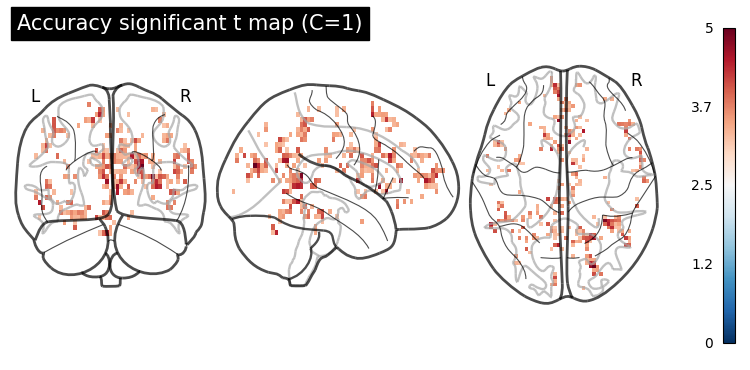

In [ ]:
# visualize t map only with p-thresholding
schlight_t_img_pthr = mask_t_map(schlight_t_img, schlight_p_img, 0.001)
plotting.plot_glass_brain(
    schlight_t_img_pthr,
    threshold=0,
    plot_abs=False,
    title="Accuracy significant t map (C=1)"
)
plotting.show()

#### cluster correction
fdr correction would generate lots of significant single voxel, not make much sense.

In [ ]:
# get ndarray data
schlight_acc_data = schlight_acc_img.get_fdata()
schlight_t_data = schlight_t_img.get_fdata()
schlight_p_data = schlight_p_img.get_fdata()
schlight_t_data_pthr = schlight_t_img_pthr.get_fdata()

In [ ]:
# check Acc range
np.nanmax(schlight_acc_data), np.nanmin(schlight_acc_data)

(np.float64(0.5347252488136292), np.float64(0.4608093500137329))

In [ ]:
# cluster_threshold: minimal cluster size in voxels
thresholded_map, threshold = threshold_stats_img(
    schlight_t_img,
    alpha=0.001,
    height_control='fpr',
    cluster_threshold=10,
    two_sided=False
)
print(f"after correction, t-value: {threshold:.3f}")
nib.save(thresholded_map, f'Final_Cluster_Corrected_T_Map_C{c_param}.nii.gz')

In [ ]:
thresholded_map = nib.load(f'Final_Cluster_Corrected_T_Map_C{c_param}.nii.gz')

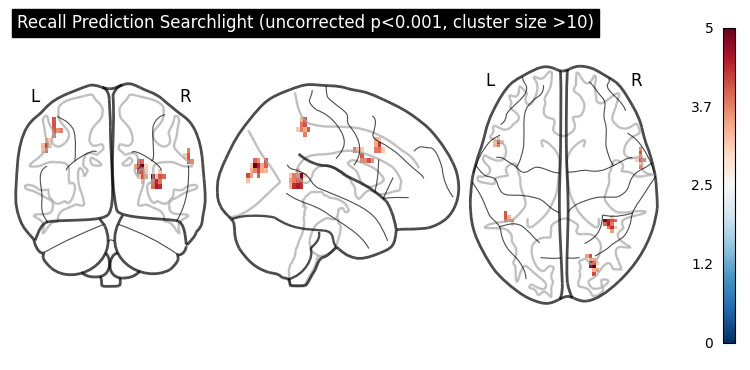

In [ ]:
# visualize cluster + p correction result
display = plotting.plot_glass_brain(
    thresholded_map,
    threshold=0,
    plot_abs=False
)
display.title("Recall Prediction Searchlight (uncorrected p<0.001, cluster size >10)", 
              size=12)
plotting.show()

In [ ]:
# get clusters table and label map
table, label_mask = get_clusters_table(
    thresholded_map,
    stat_threshold=0.001,
    cluster_threshold=0,
    two_sided=False,
    return_label_maps=True
)

In [69]:
nib.save(label_mask[0], f'Final_Cluster_label_C{c_param}.nii.gz')

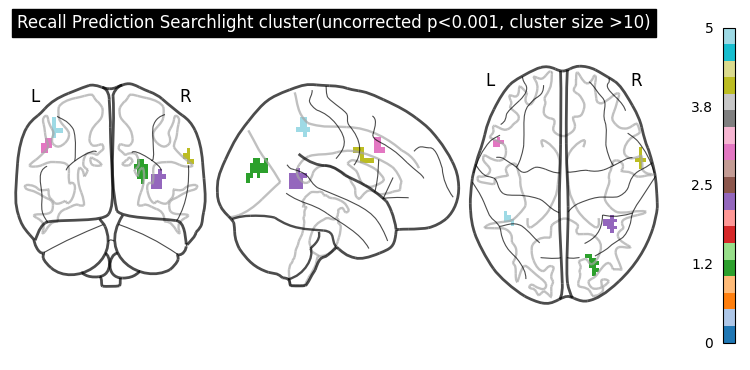

In [ ]:
# visualize label map
display = plotting.plot_glass_brain(
    label_mask[0],
    threshold=0,
    plot_abs=False,
    cmap='tab20'
)
display.title("Recall Prediction Searchlight cluster(uncorrected p<0.001, cluster size >10)", 
              size=12)
plotting.show()

In [ ]:
# know where peak is (roi)
from nilearn import datasets, image
# get image atlases
atlas_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
# define MNI - voxel transform
def get_label_from_coords(x, y, z):
    # MNI to voxel index in atlas
    # check in cortical first
    idx_cort = image.coord_transform(x, y, z, np.linalg.inv(atlas_cort.maps.affine))
    label_idx_cort = atlas_cort.maps.get_fdata()[int(idx_cort[0]), int(idx_cort[1]), int(idx_cort[2])]
    if label_idx_cort > 0:
        return atlas_cort.labels[int(label_idx_cort)]
    # then in subcortical
    idx_sub = image.coord_transform(x, y, z, np.linalg.inv(atlas_sub.maps.affine))
    label_idx_sub = atlas_sub.maps.get_fdata()[int(idx_sub[0]), int(idx_sub[1]), int(idx_sub[2])]
    if label_idx_sub > 0:
        return atlas_sub.labels[int(label_idx_sub)]
    return "background"

table['roi_label'] = table.apply(lambda row: get_label_from_coords(row['X'], row['Y'], row['Z']), axis=1)


In [22]:
table.to_csv('Final_schlight_cluster_table.csv')

In [ ]:
# voxel wise summary for ROI
from collections import Counter
coords = np.nonzero(thresholded_map.get_fdata())
cort = nib.load("atlas/cortical_mask_resample.nii.gz").get_fdata()
sub_cort = nib.load("atlas/subcortical_mask_resample.nii.gz").get_fdata()
label_df = pd.read_csv("atlas/region_voxel_summary.csv")
region_counts = Counter()
for i in range(len(coords[0])):
    x, y, z = coords[0][i], coords[1][i], coords[2][i]
    cort_label = cort[x, y, z]
    sub_cort_label = sub_cort[x, y, z]
    if cort_label !=0:
        current_region_id = cort_label
        region_type = "cortical"
    elif sub_cort_label not in [0,1,2,3,12,13,14]:
        current_region_id = sub_cort_label
        region_type = "subcortical"
    else:
        continue
    region_info = label_df[(label_df['id'] == current_region_id) & (label_df['region'] == region_type)]
    if not region_info.empty:
        region_name = region_info['Name'].values[0]
        region_counts[region_name] += 1

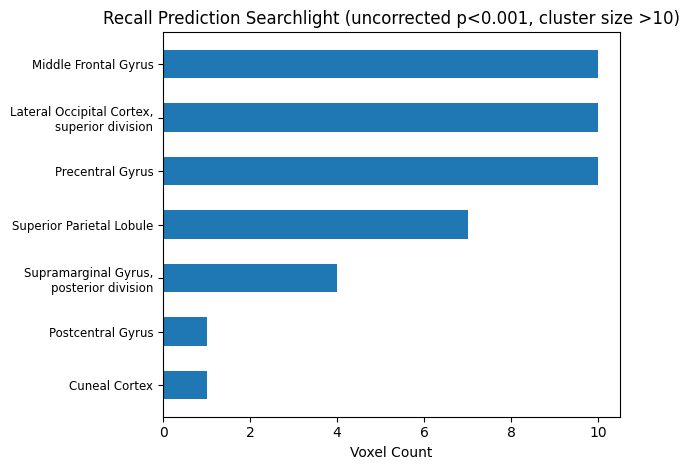

In [50]:
# visualize
import textwrap
result_df = pd.DataFrame({
    'region': list(region_counts.keys()),
    'voxel_count': list(region_counts.values())
}).sort_values('voxel_count', ascending=True) 
plt.figure()
y_pos = np.array(range(len(result_df['region'])))*1.5
plt.barh(y_pos, result_df['voxel_count'])
wrapped_labels = [textwrap.fill(region, width=25) for region in result_df['region']]
plt.yticks(y_pos, wrapped_labels, fontsize=8.5)
plt.title("Recall Prediction Searchlight (uncorrected p<0.001, cluster size >10)")
plt.xlabel('Voxel Count')
plt.tight_layout()
plt.show()